## ライブラリのインポート

In [26]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # ポップアウトウィンドウを表示しないようにする
from ple.games.flappybird import FlappyBird
from ple import PLE
from collections import defaultdict

## アニメーションの作成

In [27]:
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps
    import moviepy.editor as mpy

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

## グラフの作成

In [28]:
def make_graph(reward_per_epoch, lifetime_per_epoch):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    axL.set_title('lifetime')
    axL.grid(True)
    axL.plot(lifetime_per_epoch)
    axR.set_title('reward')
    axR.grid(True)
    axR.plot(reward_per_epoch)
    fig.show()

## 定数の宣言

In [29]:
ETA = 0.5
GAMMA = 0.99
GOAL_FRAME = 1200 # 目標フレーム数

## Agentクラス

In [30]:
class Agent:
    def __init__(self, num_actions):
        self.brain = Brain(num_actions)
    
    def update_Q_function(self, state, action, reward, observation_prime):
        self.brain.update_policy(state, action, reward, observation_prime)
    
    def get_action(self, state, episode):
        action = self.brain.decide_action(state, episode)
        return action

## Brainクラス

In [31]:
class Brain:
    
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.q_table = defaultdict(lambda: np.zeros(num_actions))

    def decide_action(self, state, episode):
        #  ε-greedy
        state_idx = self.get_state_idx(state)  # 相対位置の取得
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state_idx])  # Q値が最大の行動を選択する
        else:
            action = np.random.choice(self.num_actions)  # ランダムな行動を選択する
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Q学習を用いてQ値を更新する
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += ETA * (
            reward + GAMMA * best_q - self.q_table[state_idx][action])
    
    bucket_range_per_feature = {
        'next_next_pipe_bottom_y': 40,
        'next_next_pipe_dist_to_player': 512,
        'next_next_pipe_top_y': 40,
        'next_pipe_bottom_y': 20,
        'next_pipe_dist_to_player': 20,
        'next_pipe_top_y': 20,
        'player_vel': 4,
        'player_y': 16
    }
    
    def get_state_idx(self, state):
        # パイプの絶対位置の代わりに相対位置を使用する
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # アルファベット順に並び替える
        state_key = [k for k, v in sorted(state.items())]

        # 相対位置を返す
        state_idx = []
        for key in state_key:
            state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

## Environmentクラス

In [32]:
class Environment:
    
    def __init__(self, graph=True):
        self.game = FlappyBird()
        self.env = PLE(self.game, fps=30, display_screen=False)
        self.num_actions = len(self.env.getActionSet()) # 1
        self.agent = Agent(self.num_actions)
        self.graph=graph
    
    def run(self):
        
        from IPython.display import Image, display

        reward_per_epoch = []
        lifetime_per_epoch = []
        PRINT_EVERY_EPISODE = 500
        SHOW_GIF_EVERY_EPISODE = 5000
        NUM_EPISODE = 50000
        for episode in range(0, NUM_EPISODE):
            # 環境のリセット
            self.env.reset_game()
            # record frame
            frames = [self.env.getScreenRGB()]

            # 状態の初期化
            state = self.game.getGameState()
            cum_reward = 0  # このエピソードにおける累積報酬の和
            t = 0

            while not self.env.game_over():

                # 行動の選択
                action = self.agent.get_action(state, episode)

                # 行動を実行し、報酬を得る
                reward = self.env.act(
                        self.env.getActionSet()[action])  # パイプを超えれば、reward +=1 失敗したら reward  -= 5

                frames.append(self.env.getScreenRGB())

                # 累積報酬
                cum_reward += reward

                # 次状態を得る
                state_prime = self.game.getGameState() 

                # Agentの更新
                self.agent.update_Q_function(state, action, reward, state_prime)

                # 次のイテレーションの用意
                state = state_prime
                t += 1
            
            # 500エピソード毎にlogを出力
            if episode % PRINT_EVERY_EPISODE == 0:
                print("Episode %d finished after %f time steps" % (episode, t))
                print("cumulated reward: %f" % cum_reward)
                reward_per_epoch.append(cum_reward)
                lifetime_per_epoch.append(t)
                if len(frames) > GOAL_FRAME:
                    print("len frames:", len(frames))
                    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
                    display(clip.ipython_display(fps=60, autoplay=1, loop=1))
                    if self.graph == True:
                        make_graph(reward_per_epoch, lifetime_per_epoch)
                    break
                

            # 5000エピソード毎にアニメーションを作成
            if episode % SHOW_GIF_EVERY_EPISODE == 0:
                print("len frames:", len(frames))
                clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
                display(clip.ipython_display(fps=60, autoplay=1, loop=1))

## Main関数

  3%|▎         | 2/63 [00:00<00:03, 16.56it/s]

Episode 0 finished after 61.000000 time steps
cumulated reward: -5.000000
len frames: 62


100%|██████████| 63/63 [00:00<00:00, 187.25it/s]


Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 1000 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 1500 finished after 65.000000 time steps
cumulated reward: -5.000000
Episode 2000 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 2500 finished after 61.000000 time steps
cumulated reward: -5.000000
Episode 3000 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 3500 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 4000 finished after 91.000000 time steps
cumulated reward: -4.000000
Episode 4500 finished after 62.000000 time steps
cumulated reward: -5.000000


  5%|▍         | 6/132 [00:00<00:02, 58.57it/s]

Episode 5000 finished after 130.000000 time steps
cumulated reward: -3.000000
len frames: 131


 99%|█████████▉| 131/132 [00:00<00:00, 253.46it/s]


Episode 5500 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 6000 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 6500 finished after 247.000000 time steps
cumulated reward: 0.000000
Episode 7000 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 7500 finished after 78.000000 time steps
cumulated reward: -4.000000
Episode 8000 finished after 98.000000 time steps
cumulated reward: -4.000000
Episode 8500 finished after 72.000000 time steps
cumulated reward: -4.000000
Episode 9000 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 9500 finished after 214.000000 time steps
cumulated reward: -1.000000


  6%|▌         | 15/249 [00:00<00:01, 146.04it/s]

Episode 10000 finished after 247.000000 time steps
cumulated reward: 0.000000
len frames: 248


100%|██████████| 249/249 [00:00<00:00, 269.44it/s]


Episode 10500 finished after 211.000000 time steps
cumulated reward: -1.000000
Episode 11000 finished after 175.000000 time steps
cumulated reward: -2.000000
Episode 11500 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 12000 finished after 124.000000 time steps
cumulated reward: -3.000000
Episode 12500 finished after 98.000000 time steps
cumulated reward: -4.000000
Episode 13000 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 13500 finished after 247.000000 time steps
cumulated reward: 0.000000
Episode 14000 finished after 62.000000 time steps
cumulated reward: -5.000000
Episode 14500 finished after 776.000000 time steps
cumulated reward: 14.000000


  4%|▎         | 5/136 [00:00<00:02, 49.05it/s]

Episode 15000 finished after 134.000000 time steps
cumulated reward: -3.000000
len frames: 135


 99%|█████████▉| 135/136 [00:00<00:00, 241.75it/s]


Episode 15500 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 16000 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 16500 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 17000 finished after 134.000000 time steps
cumulated reward: -3.000000
Episode 17500 finished after 241.000000 time steps
cumulated reward: 0.000000


  0%|          | 6/1210 [00:00<00:20, 59.49it/s]

Episode 18000 finished after 1208.000000 time steps
cumulated reward: 26.000000
len frames: 1209


100%|█████████▉| 1209/1210 [00:04<00:00, 286.23it/s]


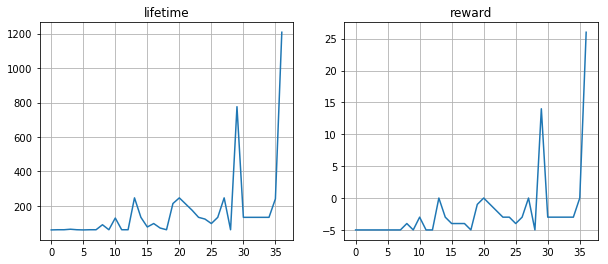

In [33]:
flappybird_env = Environment()
flappybird_env.run()